In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px #visualize interactive image
import ace_tools_open as tools;

In [2]:
# Load Data
market_data = pd.read_csv("../data/processed/market_data_ffill.csv", index_col='Date', parse_dates=True)
vix_data = pd.read_csv("../data/processed/vix_ffill.csv", index_col='Date', parse_dates=True)
macro_data = pd.read_csv("../data/raw/macro_monthly.csv", index_col='Date', parse_dates=True)
RIR_data = pd.read_csv("../data/processed/RIR_ffill.csv", index_col='Date', parse_dates=True)
usd_data = pd.read_csv("../data/processed/usd_ffill.csv", index_col='Date', parse_dates=True)

gold_spot_USD = pd.read_csv("../data/raw/gold_spot_WGC.csv", index_col='Date', parse_dates=True)
gold_spot_USD = gold_spot_USD.rename(columns={"USD": "Gold_Spot"})

gpr_data = pd.read_excel("../data/raw/data_gpr_export.xls", header = 0)
gpr_data = gpr_data.rename(columns={"month": "Date"})
gpr_data = gpr_data.set_index("Date")
gpr_data = gpr_data[["GPR", "GPRT", "GPRA"]]

# Turn to Daily and ffill missing date
gpr_data = gpr_data.resample('D').ffill()
macro_data = macro_data.resample('D').ffill()

In [3]:
datasets = {
    "market": market_data,
    "usd": usd_data,
    "macro": macro_data,
    "rir": RIR_data,
    "vix": vix_data,
    "gpr": gpr_data,
    "gold": gold_spot_USD
}

start_dates = []

for name, df in datasets.items():
    df_valid_start = df.apply(lambda col: col.first_valid_index())
    df_start = df_valid_start.max()
    start_dates.append(df_start)

    print(f"{name}: {df_start.date()}")

latest_start = max(start_dates)
print(f"lastest date: {latest_start.date()}")


market: 2004-11-18
usd: 2006-01-02
macro: 2000-01-01
rir: 2003-01-02
vix: 2006-01-03
gpr: 1985-01-01
gold: 1978-01-31
lastest date: 2006-01-03


In [4]:

gold_spot_USD = gold_spot_USD.loc[latest_start:]
market_data = market_data.loc[latest_start:]
usd_data = usd_data.loc[latest_start:]
macro_daily = macro_data.loc[latest_start:]
RIR_data = RIR_data.loc[latest_start:]
vix_data = vix_data.loc[latest_start:]
gpr_daily = gpr_data.loc[latest_start:]

In [5]:
combined_data = gold_spot_USD \
    .join(market_data, how='left') \
    .join(usd_data, how='left') \
    .join(macro_data, how='left') \
    .join(RIR_data, how='left') \
    .join(vix_data, how='left') \
    .join(gpr_data, how='left')


tools.display_dataframe_to_user(name="Combined dataFrame", dataframe=combined_data)

combined_data.to_csv("../data/combined_data.csv")

Combined dataFrame


Loading ITables v2.4.3 from the internet... (need help?)


In [10]:
combined_data.info()
combined_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 233 entries, 2006-01-31 to 2025-05-30
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gold_Spot           233 non-null    float64
 1   Crude_Oil           228 non-null    float64
 2   Gold_Futures        228 non-null    float64
 3   Gold_ETF            228 non-null    float64
 4   Silver_Fututes      228 non-null    float64
 5   SP_500              228 non-null    float64
 6   NASDAQ              228 non-null    float64
 7   USD_Index           229 non-null    float64
 8   CPI                 233 non-null    float64
 9   Fed_Funds_Rate      233 non-null    float64
 10  M2_Supply           233 non-null    float64
 11  Unemployment        233 non-null    float64
 12  Treasury_Yield_10Y  233 non-null    float64
 13  Real_Interest_Rate  228 non-null    float64
 14  ^VIX                228 non-null    float64
 15  GPR                 231 non-null    fl

Gold_Spot             0
Crude_Oil             5
Gold_Futures          5
Gold_ETF              5
Silver_Fututes        5
SP_500                5
NASDAQ                5
USD_Index             4
CPI                   0
Fed_Funds_Rate        0
M2_Supply             0
Unemployment          0
Treasury_Yield_10Y    0
Real_Interest_Rate    5
^VIX                  5
GPR                   2
GPRT                  2
GPRA                  2
dtype: int64

# 1. Understand - Explore data

## Gold Spot

In [6]:
gold_spot = pd.read_excel(
    "../data/raw/Gold_price_averages_in_a range_of_currencies_since_1978.xlsx",
    sheet_name='Monthly_Avg',
    header=5
)
gold_spot = gold_spot.loc[:, ~gold_spot.columns.str.startswith("Unnamed")]
gold_spot["Date"] = pd.to_datetime(gold_spot["Date"], errors="coerce") 
gold_spot.set_index("Date", inplace=True)
print(gold_spot.columns.tolist())

['USD', 'EUR', 'JPY', 'GBP', 'CAD', 'CHF', 'INR', 'CNY', 'TRY', 'SAR', 'IDR', 'AED', 'THB', 'VND', 'EGP', 'KRW', 'RUB', 'ZAR', 'AUD']


In [39]:
gold_spot.isnull().sum()

USD      0
EUR      0
JPY      1
GBP      0
CAD      1
CHF      1
INR      1
CNY     73
TRY     49
SAR      1
IDR      1
AED      1
THB      1
VND    132
EGP    120
KRW      1
RUB    169
ZAR      1
AUD      1
dtype: int64

In [40]:
gold_spot.describe()

,USD,EUR,JPY,GBP,CAD,CHF,INR,CNY,TRY,SAR,IDR,AED,THB,VND,EGP,KRW,RUB,ZAR,AUD
count,569.000000,569.000000,568.000000,569.000000,568.000000,568.000000,568.000000,496.000000,520.000000,568.000000,5.680000e+02,568.000000,568.000000,4.370000e+02,449.000000,5.680000e+02,400.000000,568.000000,568.000000
mean,799.633761,678.210598,99325.684458,543.077985,997.253322,907.011286,44022.345640,5744.604998,6371.255387,2983.963074,8.263982e+06,2942.260964,25614.694511,1.863627e+07,13361.596943,8.798659e+05,50509.960316,8408.641454,1046.322018
std,610.745038,538.403426,76192.909713,479.748257,782.347625,471.401389,52811.914715,4395.808789,17719.000568,2303.240343,1.030856e+07,2242.510622,20949.287101,1.695786e+07,25489.539296,8.219739e+05,59954.589664,11384.910383,860.562782
min,207.830000,129.208100,28312.980370,104.625990,269.548230,378.772810,1852.847000,845.609630,0.083210,754.088370,1.417964e+05,869.396010,4582.177750,1.577365e+06,874.970000,1.111866e+05,148.353480,197.003410,198.596630
25%,355.100000,306.124430,42915.112500,217.932560,458.682720,501.160825,6927.656985,2252.467500,4.910680,1318.378553,7.183258e+05,1304.490970,9691.732638,4.123598e+06,1181.467140,3.055886e+05,7701.481827,996.876285,476.318463
50%,431.280000,380.706050,78104.872740,262.780840,540.229430,762.459850,13666.533900,3452.460000,548.070000,1579.505000,2.893379e+06,1584.290285,13013.080000,1.063084e+07,3599.930000,3.951678e+05,22268.700000,2447.695000,564.665000
75%,1251.850000,1040.920000,134111.395000,858.660000,1478.207500,1224.497500,78140.790000,8473.027500,3053.247500,4707.455000,1.508655e+07,4604.980000,41231.505000,2.972158e+07,10794.640000,1.403668e+06,75953.650000,13560.195000,1520.815000
max,3277.990000,2908.780000,475098.620000,2453.520000,4546.660000,2721.910000,279596.630000,23650.280000,127251.730000,12295.600000,5.396645e+07,12040.040000,108366.900000,8.510954e+07,164659.820000,4.624691e+06,276997.430000,60732.410000,5109.260000


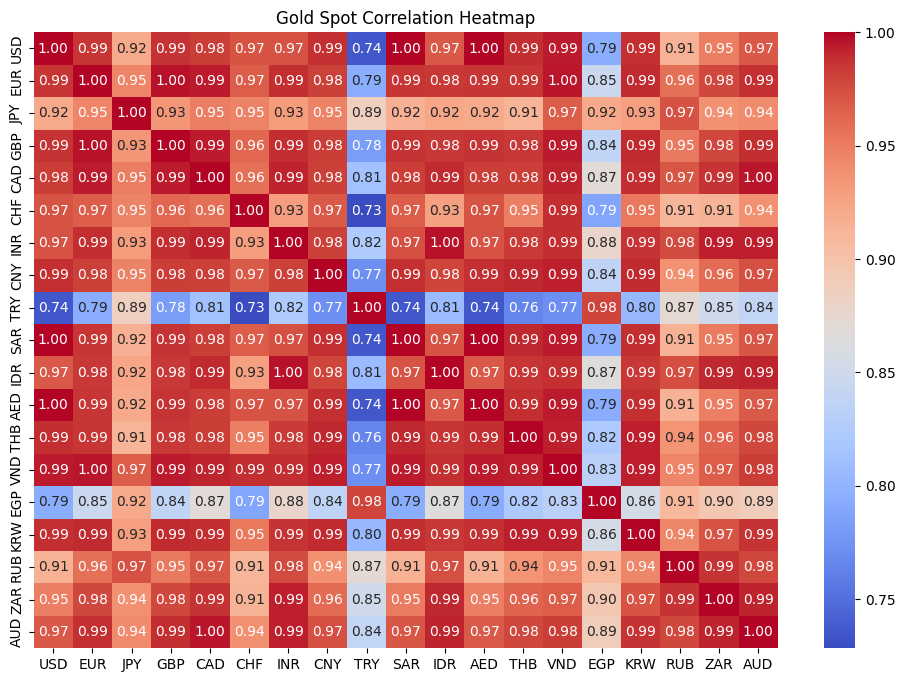

In [29]:
gold_corr = gold_spot.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(gold_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Gold Spot Correlation Heatmap")
plt.show()

## Static PNG Charts for EDA Page

In [16]:
# 1. Gold Currency Correlation Heatmap
import plotly.graph_objects as go
from pathlib import Path

gold_corr = gold_spot.corr()

fig = go.Figure(data=go.Heatmap(
    z=gold_corr.values,
    x=gold_corr.columns,
    y=gold_corr.columns,
    colorscale='RdBu_r',
    zmid=0,
    text=gold_corr.values,
    texttemplate='%{text:.2f}',
    textfont={"size": 9},
    colorbar=dict(title="Correlation", len=0.8)
))

fig.update_layout(
    title="Gold Price Correlation Across Currencies",
    width=1000,
    height=900,
    xaxis_title="Currency/Product",
    yaxis_title="Currency/Product",
    font=dict(size=10),
    template='plotly_white',
    xaxis_tickangle=-45
)

fig.show()

RESULT_DIR = Path("../results/explore")
RESULT_DIR.mkdir(parents=True, exist_ok=True)
fig.write_image(RESULT_DIR / "gold_currency_heatmap.png", width=1000, height=900, scale=2)

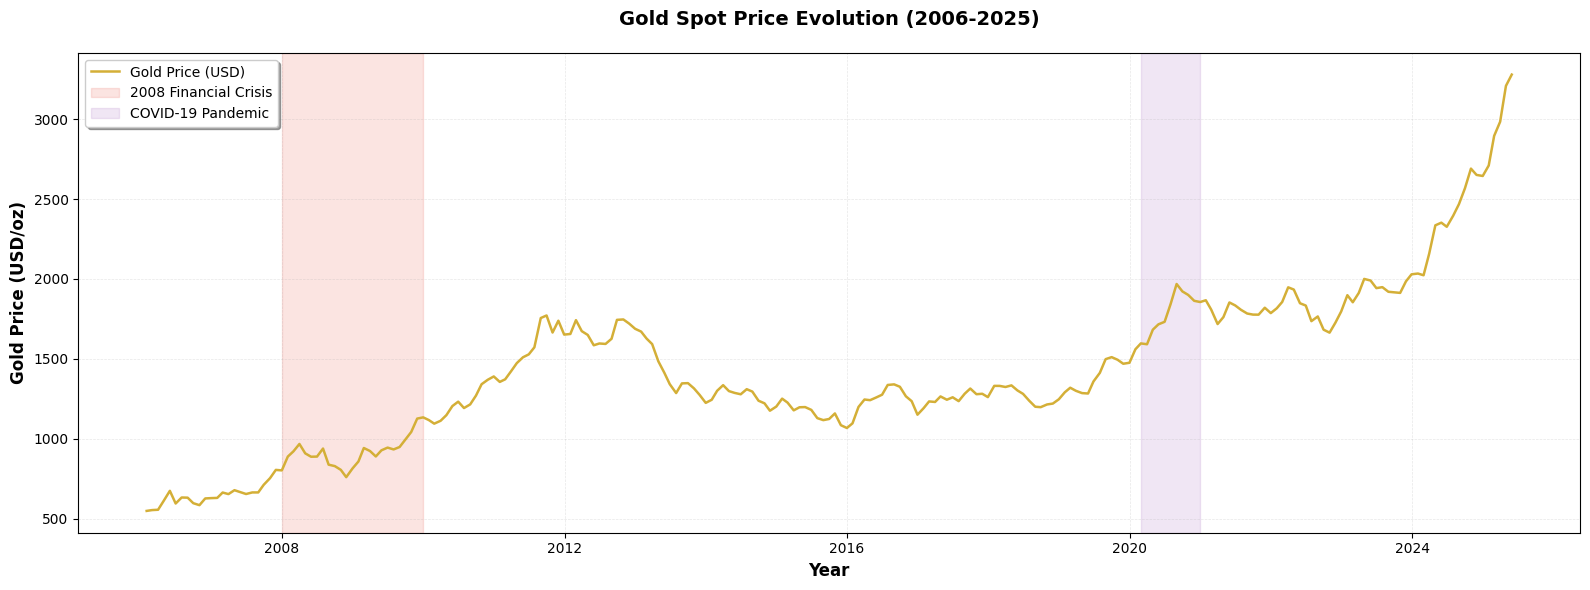

In [8]:
# 2. Gold Price Timeseries with Event Annotations
combined = pd.read_csv("../data/combined_data.csv", index_col='Date', parse_dates=True)
combined.rename(columns={"Silver_Fututes": "Silver_Futures"}, inplace=True)

fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(combined.index, combined['Gold_Spot'], linewidth=1.8, color='#D4AF37', label='Gold Price (USD)')

ax.axvspan('2008-01-01', '2009-12-31', alpha=0.15, color='#E74C3C', label='2008 Financial Crisis')
ax.axvspan('2020-03-01', '2020-12-31', alpha=0.15, color='#9B59B6', label='COVID-19 Pandemic')

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Gold Price (USD/oz)', fontsize=12, fontweight='bold')
ax.set_title('Gold Spot Price Evolution (2006-2025)', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper left', frameon=True, shadow=True, fontsize=10)
ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
# plt.savefig(RESULT_DIR / "gold_price_timeseries.png", dpi=300, bbox_inches='tight')
plt.show()

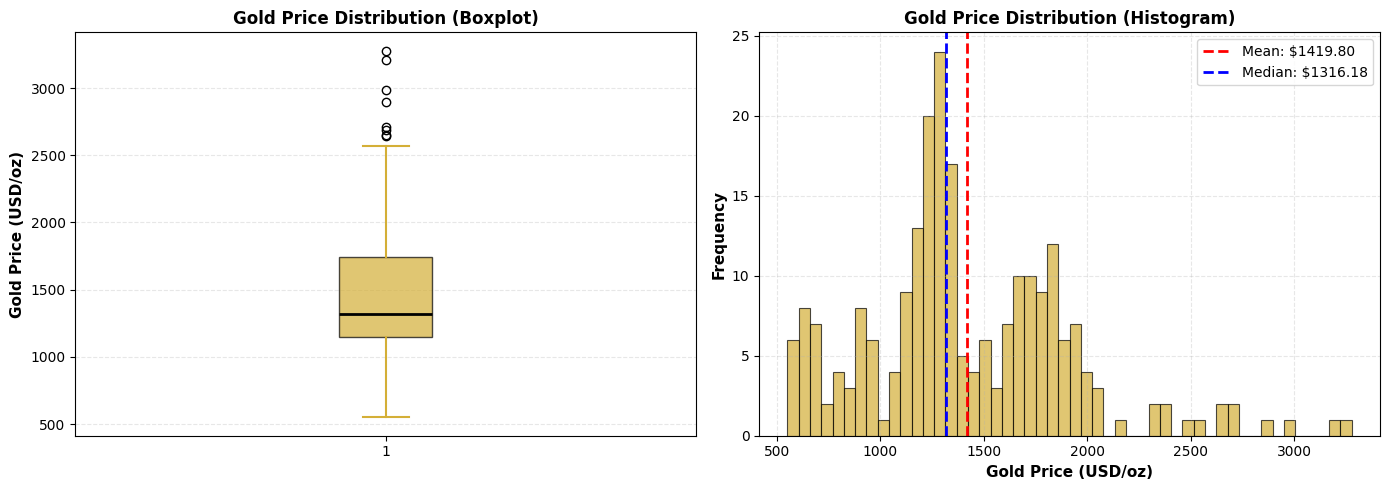

In [9]:
# 3. Gold Distribution Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

gold_color = '#D4AF37'

axes[0].boxplot(combined['Gold_Spot'], vert=True, patch_artist=True,
                boxprops=dict(facecolor=gold_color, alpha=0.7),
                medianprops=dict(color='black', linewidth=2),
                whiskerprops=dict(color=gold_color, linewidth=1.5),
                capprops=dict(color=gold_color, linewidth=1.5))
axes[0].set_ylabel('Gold Price (USD/oz)', fontsize=11, fontweight='bold')
axes[0].set_title('Gold Price Distribution (Boxplot)', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

axes[1].hist(combined['Gold_Spot'], bins=50, color=gold_color, alpha=0.7, edgecolor='black', linewidth=0.8)
axes[1].axvline(combined['Gold_Spot'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: ${combined['Gold_Spot'].mean():.2f}")
axes[1].axvline(combined['Gold_Spot'].median(), color='blue', linestyle='--', linewidth=2, label=f"Median: ${combined['Gold_Spot'].median():.2f}")
axes[1].set_xlabel('Gold Price (USD/oz)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1].set_title('Gold Price Distribution (Histogram)', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(RESULT_DIR / "gold_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

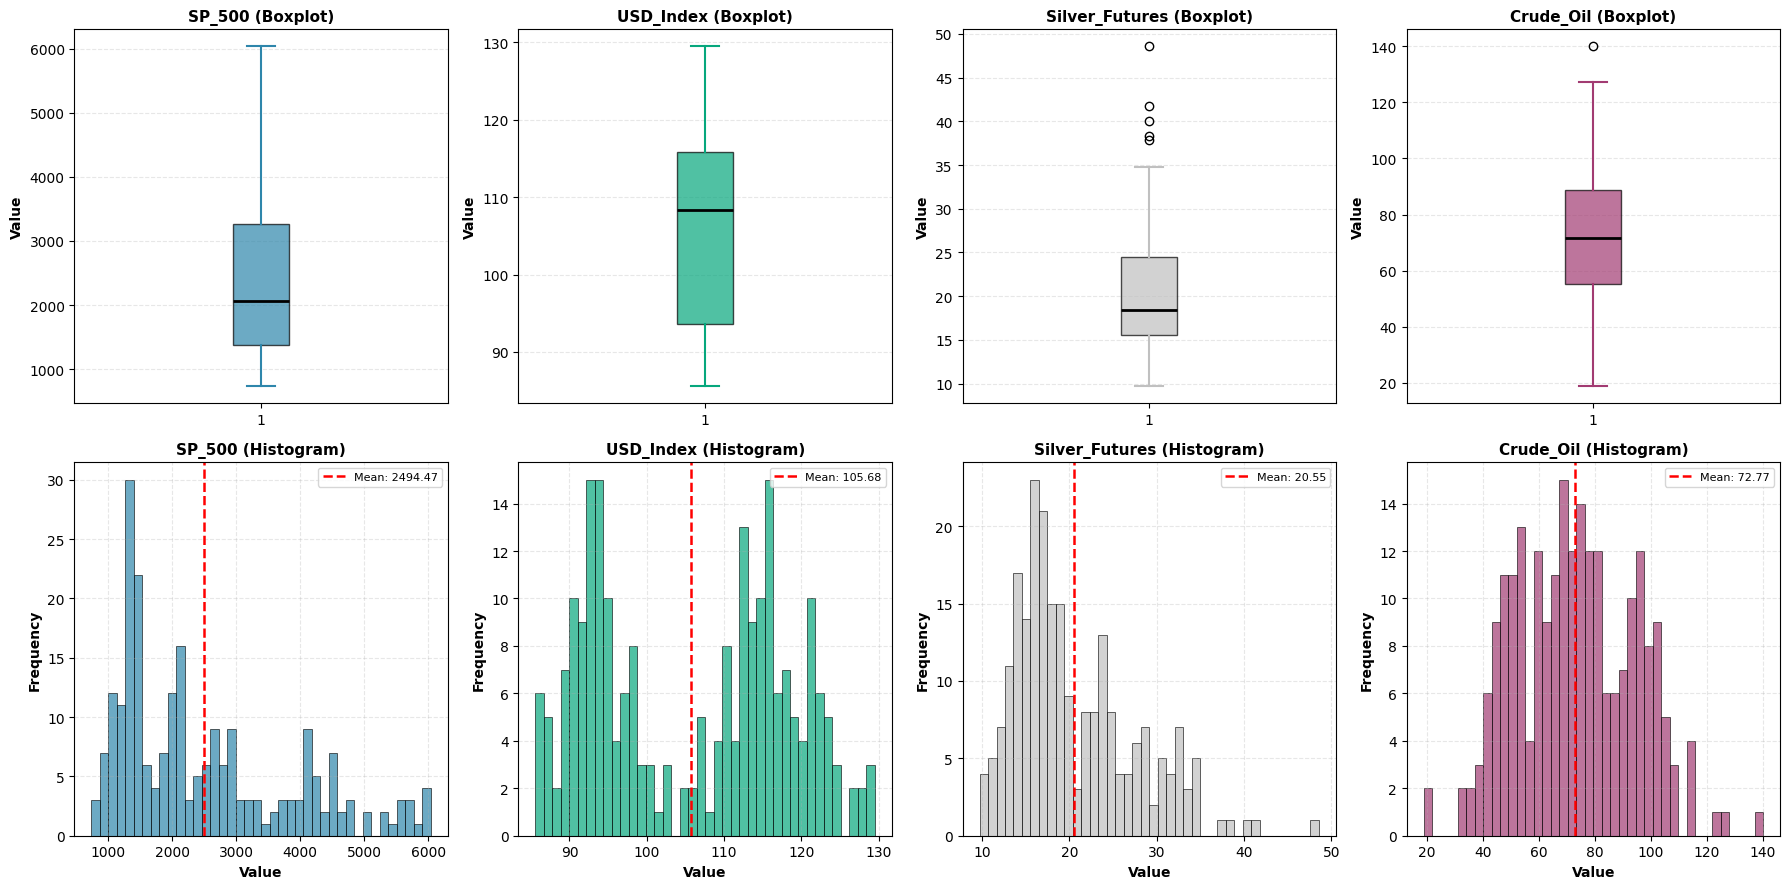

In [13]:
# 4. Market Indicators Distribution
market_features = ['SP_500', 'USD_Index', 'Silver_Futures', 'Crude_Oil']
market_colors = ['#2E86AB', '#06A77D', '#C0C0C0', '#A23B72']

fig, axes = plt.subplots(2, 4, figsize=(18, 9))

for idx, (feature, color) in enumerate(zip(market_features, market_colors)):
    col = idx
    
    axes[0, col].boxplot(combined[feature].dropna(), vert=True, patch_artist=True,
                         boxprops=dict(facecolor=color, alpha=0.7),
                         medianprops=dict(color='black', linewidth=2),
                         whiskerprops=dict(color=color, linewidth=1.5),
                         capprops=dict(color=color, linewidth=1.5))
    axes[0, col].set_ylabel('Value', fontsize=10, fontweight='bold')
    axes[0, col].set_title(f'{feature} (Boxplot)', fontsize=11, fontweight='bold')
    axes[0, col].grid(axis='y', alpha=0.3, linestyle='--')
    
    axes[1, col].hist(combined[feature].dropna(), bins=40, color=color, alpha=0.7, edgecolor='black', linewidth=0.6)
    axes[1, col].axvline(combined[feature].mean(), color='red', linestyle='--', linewidth=1.8, 
                         label=f"Mean: {combined[feature].mean():.2f}")
    axes[1, col].set_xlabel('Value', fontsize=10, fontweight='bold')
    axes[1, col].set_ylabel('Frequency', fontsize=10, fontweight='bold')
    axes[1, col].set_title(f'{feature} (Histogram)', fontsize=11, fontweight='bold')
    axes[1, col].legend(loc='upper right', fontsize=8)
    axes[1, col].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(RESULT_DIR / "market_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

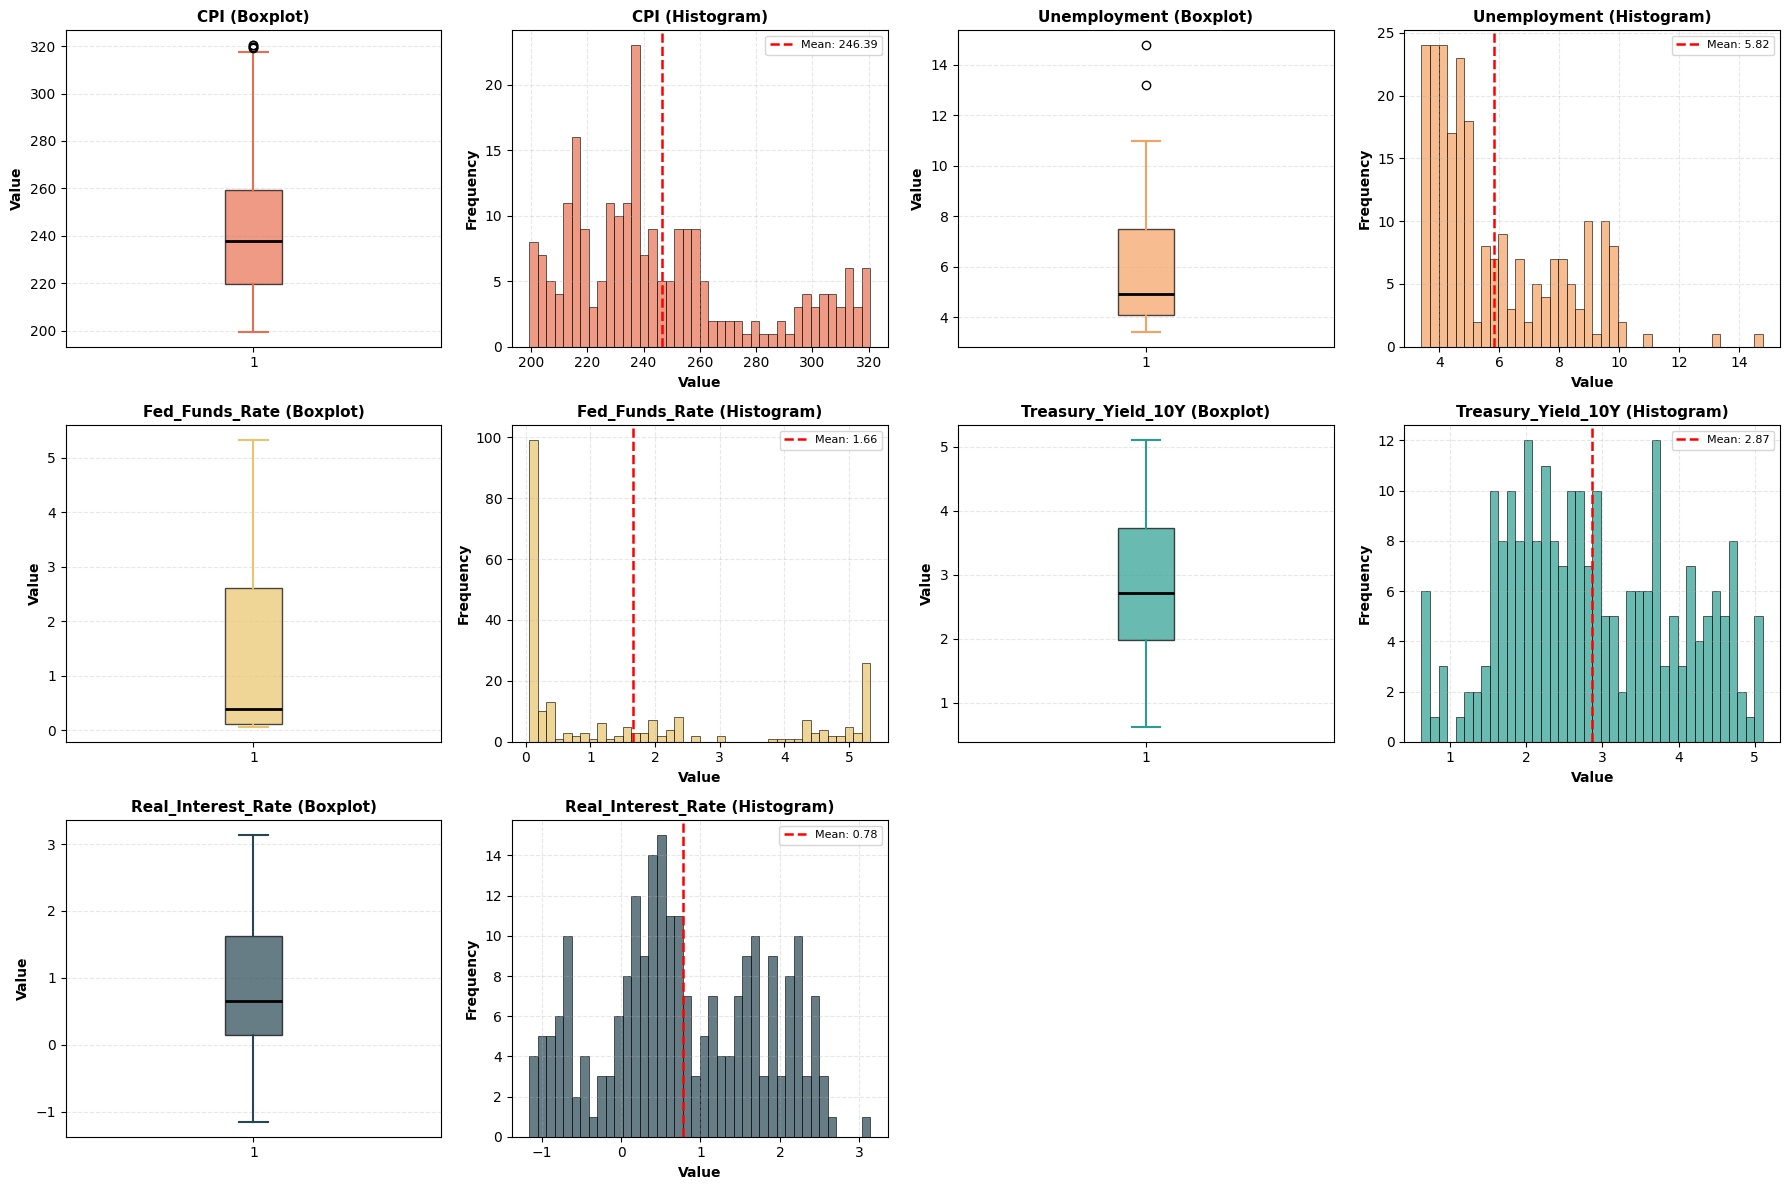

In [14]:
# 5. Macroeconomic Indicators Distribution
macro_features = ['CPI', 'Unemployment', 'Fed_Funds_Rate', 'Treasury_Yield_10Y', 'Real_Interest_Rate']
macro_colors = ['#E76F51', '#F4A261', '#E9C46A', '#2A9D8F', '#264653']

fig, axes = plt.subplots(3, 4, figsize=(18, 12))

for idx, (feature, color) in enumerate(zip(macro_features, macro_colors)):
    row, col = divmod(idx * 2, 4)
    
    if row < 3 and col < 4:
        axes[row, col].boxplot(combined[feature].dropna(), vert=True, patch_artist=True,
                               boxprops=dict(facecolor=color, alpha=0.7),
                               medianprops=dict(color='black', linewidth=2),
                               whiskerprops=dict(color=color, linewidth=1.5),
                               capprops=dict(color=color, linewidth=1.5))
        axes[row, col].set_ylabel('Value', fontsize=10, fontweight='bold')
        axes[row, col].set_title(f'{feature} (Boxplot)', fontsize=11, fontweight='bold')
        axes[row, col].grid(axis='y', alpha=0.3, linestyle='--')
    
    row_hist, col_hist = divmod(idx * 2 + 1, 4)
    if row_hist < 3 and col_hist < 4:
        axes[row_hist, col_hist].hist(combined[feature].dropna(), bins=40, color=color, alpha=0.7, 
                                      edgecolor='black', linewidth=0.6)
        axes[row_hist, col_hist].axvline(combined[feature].mean(), color='red', linestyle='--', 
                                         linewidth=1.8, label=f"Mean: {combined[feature].mean():.2f}")
        axes[row_hist, col_hist].set_xlabel('Value', fontsize=10, fontweight='bold')
        axes[row_hist, col_hist].set_ylabel('Frequency', fontsize=10, fontweight='bold')
        axes[row_hist, col_hist].set_title(f'{feature} (Histogram)', fontsize=11, fontweight='bold')
        axes[row_hist, col_hist].legend(loc='upper right', fontsize=8)
        axes[row_hist, col_hist].grid(alpha=0.3, linestyle='--')

for i in range(2, 4):
    axes[2, i].axis('off')

plt.tight_layout()
plt.savefig(RESULT_DIR / "macro_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

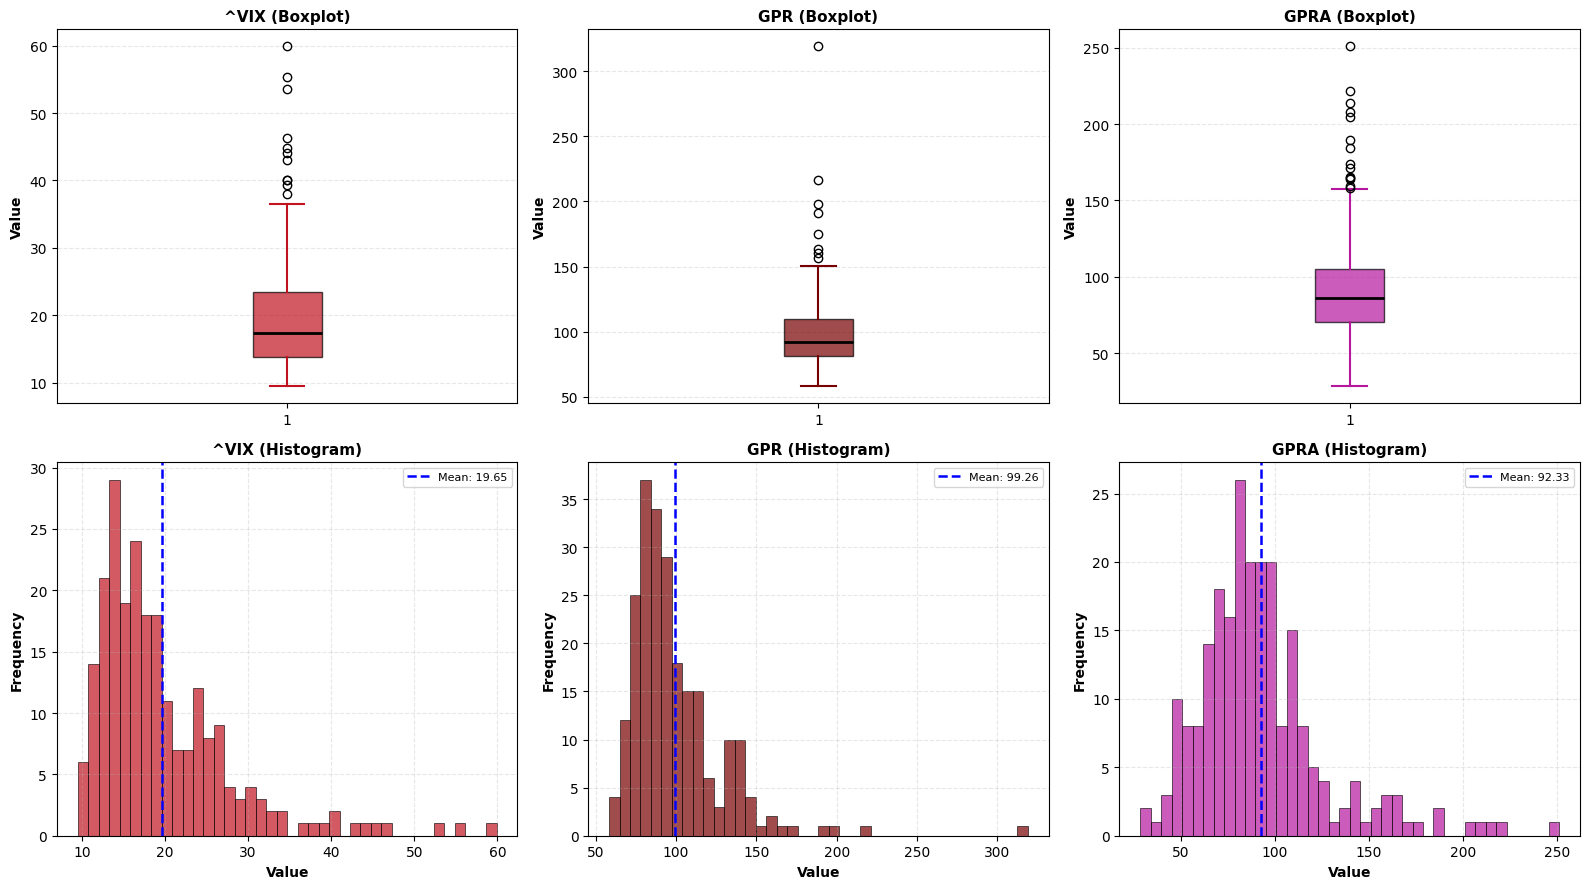

In [15]:
# 6. Volatility & Risk Indicators Distribution
volatility_features = ['^VIX', 'GPR', 'GPRA']
volatility_colors = ['#C1121F', '#780000', '#B5179E']

fig, axes = plt.subplots(2, 3, figsize=(16, 9))

for idx, (feature, color) in enumerate(zip(volatility_features, volatility_colors)):
    axes[0, idx].boxplot(combined[feature].dropna(), vert=True, patch_artist=True,
                         boxprops=dict(facecolor=color, alpha=0.7),
                         medianprops=dict(color='black', linewidth=2),
                         whiskerprops=dict(color=color, linewidth=1.5),
                         capprops=dict(color=color, linewidth=1.5))
    axes[0, idx].set_ylabel('Value', fontsize=10, fontweight='bold')
    axes[0, idx].set_title(f'{feature} (Boxplot)', fontsize=11, fontweight='bold')
    axes[0, idx].grid(axis='y', alpha=0.3, linestyle='--')
    
    axes[1, idx].hist(combined[feature].dropna(), bins=40, color=color, alpha=0.7, edgecolor='black', linewidth=0.6)
    axes[1, idx].axvline(combined[feature].mean(), color='blue', linestyle='--', linewidth=1.8,
                         label=f"Mean: {combined[feature].mean():.2f}")
    axes[1, idx].set_xlabel('Value', fontsize=10, fontweight='bold')
    axes[1, idx].set_ylabel('Frequency', fontsize=10, fontweight='bold')
    axes[1, idx].set_title(f'{feature} (Histogram)', fontsize=11, fontweight='bold')
    axes[1, idx].legend(loc='upper right', fontsize=8)
    axes[1, idx].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(RESULT_DIR / "volatility_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# 7. Full Feature Correlation Matrix
corr_matrix = combined.corr()

fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale='RdBu_r',
    zmid=0,
    text=corr_matrix.values,
    texttemplate='%{text:.2f}',
    textfont={"size": 8},
    colorbar=dict(title="Correlation", len=0.85)
))

fig.update_layout(
    title="Feature Correlation Matrix (All Variables)",
    width=1100,
    height=1000,
    xaxis_title="Features",
    yaxis_title="Features",
    font=dict(size=10),
    template='plotly_white',
    xaxis_tickangle=-90
)

fig.show()

fig.write_image(RESULT_DIR / "correlation_heatmap.png", width=1100, height=1000, scale=2)

In [17]:
# Interactive Plotly Heatmap for all currencies
import plotly.graph_objects as go

gold_corr = gold_spot.corr()

fig = go.Figure(data=go.Heatmap(
    z=gold_corr.values,
    x=gold_corr.columns,
    y=gold_corr.columns,
    colorscale='RdBu_r',
    zmid=0,
    text=gold_corr.values,
    texttemplate='%{text:.2f}',
    textfont={"size": 10},
    colorbar=dict(title="Correlation")
))

fig.update_layout(
    title="Gold Price Correlation Heatmap (All Currencies & Products)",
    width=900,
    height=800,
    xaxis_title="Currency/Product",
    yaxis_title="Currency/Product"
)

fig.show()

In [18]:
# Save the figure as JSON for Reflex app
import json

# Export figure to JSON
fig_json = fig.to_json()

# Save to file
with open("../goldsight/data/cache/gold_currency_heatmap.json", "w") as f:
    f.write(fig_json)

print("Saved heatmap to goldsight/data/cache/gold_currency_heatmap.json")

Saved heatmap to goldsight/data/cache/gold_currency_heatmap.json


Text(0, 0.5, 'JPY')

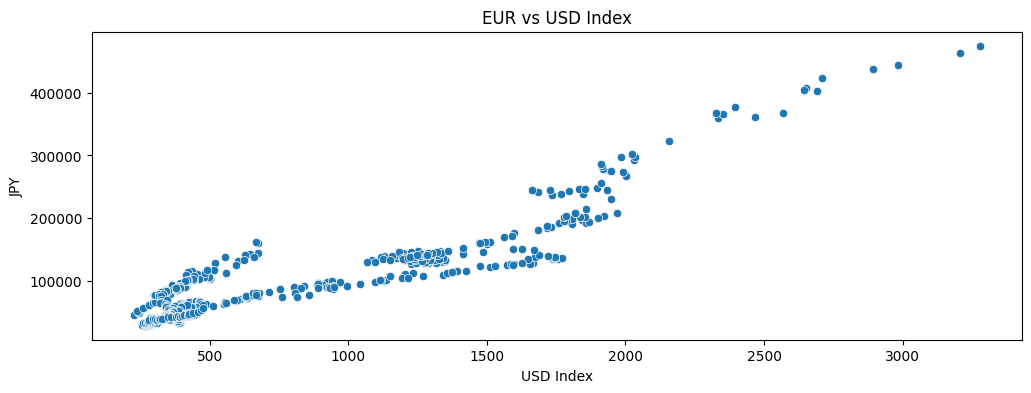

In [13]:
plt.figure(figsize=(12,4))

sns.scatterplot(data=gold_spot, x='USD', y='JPY')
plt.title("EUR vs USD Index")
plt.xlabel("USD Index")
plt.ylabel("JPY")

In [43]:
full_range = pd.date_range(start=usd_data.index.min(), end=usd_data.index.max(), freq="D")
usd_index_full = usd_data.reindex(full_range)
usd_index_full.index.name = "Date"

In [44]:
usd_data.isnull().sum()

USD_Index    194
dtype: int64

## Combined Data

In [8]:
df = combined_data.copy()

In [9]:
df.info

<bound method DataFrame.info of             Gold_Spot  Crude_Oil  Gold_Futures    Gold_ETF  Silver_Fututes  \
Date                                                                         
2006-01-31     549.86  67.919998    570.799988   56.700001        9.850000   
2006-02-28     555.00  61.410000    561.599976   56.070000        9.720000   
2006-03-31     557.09  66.629997    581.799988   58.099998       11.480000   
2006-04-28     610.65  71.879997    651.799988   65.089996       13.510000   
2006-05-31     675.39  71.290001    642.500000   64.230003       12.398000   
...               ...        ...           ...         ...             ...   
2025-01-31    2709.69  72.529999   2812.500000  258.559998       32.127998   
2025-02-28    2894.73  69.760002   2836.800049  263.269989       31.219000   
2025-03-31    2983.25  71.480003   3122.800049  288.140015       34.457001   
2025-04-30    3207.48  58.209999   3305.000000  303.769989       32.530998   
2025-05-30    3277.99  60.790001

Comment:
- All columns are numericals cols

In [48]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Gold_Spot,233.0,1419.796395,500.697016,549.860000,1151.400000,1316.180000,1742.620000,3277.990000
Crude_Oil,222.0,72.819505,21.623623,18.840000,54.392501,71.899998,90.480001,140.000000
Gold_Futures,222.0,1376.213514,438.692317,561.599976,1134.074982,1307.350036,1713.550049,2738.300049
Gold_ETF,222.0,131.314234,39.663886,56.070000,109.332502,124.404999,163.802505,253.509995
Silver_Fututes,222.0,20.177275,6.771277,9.720000,15.491750,18.099500,23.924250,48.584000
S&P_500,222.0,2394.074771,1261.245106,735.090027,1364.127502,2059.319946,3042.622559,6032.379883
NASDAQ,222.0,6414.211121,4591.293563,1377.839966,2604.677491,4784.069825,8833.529786,19218.169920
USD_Index,224.0,105.276412,12.149323,85.599900,93.598275,107.104550,115.573375,129.488000
CPI,227.0,244.453101,30.934380,199.300000,219.025500,237.498000,257.977500,316.449000
Fed_Funds_Rate,227.0,1.593128,1.952420,0.050000,0.115000,0.370000,2.400000,5.330000


In [49]:
null_count = df.isnull().sum()
null_percent = (null_count / len(df)) * 100

print(null_count)
print(null_percent)


Gold_Spot              0
Crude_Oil             11
Gold_Futures          11
Gold_ETF              11
Silver_Fututes        11
S&P_500               11
NASDAQ                11
USD_Index              9
CPI                    6
Fed_Funds_Rate         6
M2_Supply              6
Unemployment           6
Treasury_Yield_10Y     6
Real_Interest_Rate    10
^VIX                   5
GPR                    2
GPRT                   2
GPRA                   2
dtype: int64
Gold_Spot             0.000000
Crude_Oil             4.721030
Gold_Futures          4.721030
Gold_ETF              4.721030
Silver_Fututes        4.721030
S&P_500               4.721030
NASDAQ                4.721030
USD_Index             3.862661
CPI                   2.575107
Fed_Funds_Rate        2.575107
M2_Supply             2.575107
Unemployment          2.575107
Treasury_Yield_10Y    2.575107
Real_Interest_Rate    4.291845
^VIX                  2.145923
GPR                   0.858369
GPRT                  0.858369
GPRA      

## Boxplot and Histogram

In [7]:
gold_price = ["Gold_Spot", "Gold_Futures"]
market_indicator = ["Crude_Oil", "Silver_Fututes", "SP_500", "NASDAQ", "USD_Index", "Gold_ETF"]
macroeconomic = ["CPI", "Real_Interest_Rate", "M2_Supply", "Fed_Funds_Rate", "Unemployment", "Treasury_Yield_10Y"]
votatility = ["^VIX", "GPR", "GPRT", "GPRA"]

### Gold Price

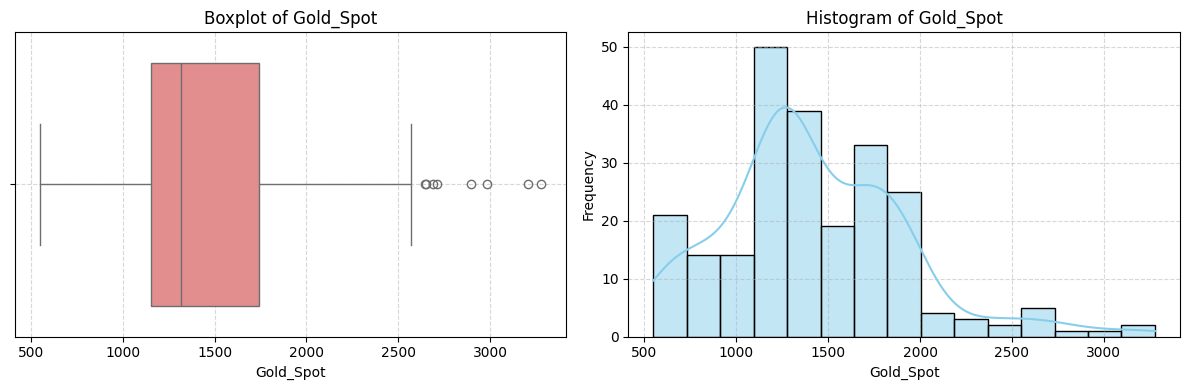

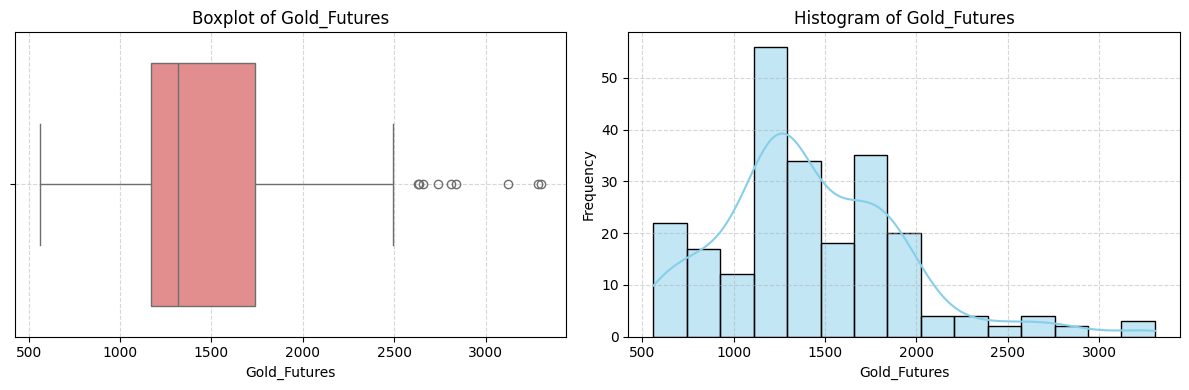

In [15]:
for col in gold_price:
    fig, axes = plt.subplots(1,2, figsize=(12,4))

    sns.histplot(data=df, x=col, kde=True, ax=axes[1], color='skyblue', edgecolor='black')
    axes[1].set_title(f"Histogram of {col}")
    axes[1].set_xlabel(col)
    axes[1].set_ylabel("Frequency")
    axes[1].grid(True, linestyle='--', alpha=0.5)

    sns.boxplot(x=df[col], ax=axes[0], color='lightcoral')
    axes[0].set_title(f"Boxplot of {col}")
    axes[0].set_xlabel(col)
    axes[0].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

In [19]:
# Interactive Gold Price Time Series with Event Highlights
import plotly.graph_objects as go

fig = go.Figure()

# Main gold price line
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['Gold_Spot'],
    mode='lines',
    name='Gold Spot Price',
    line=dict(color='goldenrod', width=2),
    hovertemplate='<b>Date</b>: %{x|%Y-%m-%d}<br><b>Price</b>: $%{y:.2f}<extra></extra>'
))

# 2008 Financial Crisis highlight (Sep 2008 - Mar 2009)
fig.add_vrect(
    x0="2008-09-01", x1="2009-03-31",
    fillcolor="red", opacity=0.15,
    layer="below", line_width=0,
    annotation_text="2008 Financial Crisis",
    annotation_position="top left",
    annotation=dict(font_size=10, font_color="darkred")
)

# COVID-19 Pandemic highlight (Mar 2020 - Dec 2020)
fig.add_vrect(
    x0="2020-03-01", x1="2020-12-31",
    fillcolor="purple", opacity=0.15,
    layer="below", line_width=0,
    annotation_text="COVID-19 Pandemic",
    annotation_position="top left",
    annotation=dict(font_size=10, font_color="darkviolet")
)

# 2024 All-Time High annotation
fig.add_annotation(
    x="2024-10-01", y=2700,
    text="2024 ATH: $2,700",
    showarrow=True,
    arrowhead=2,
    arrowsize=1,
    arrowwidth=2,
    arrowcolor="goldenrod",
    ax=-50, ay=-40,
    font=dict(size=11, color="goldenrod"),
    bgcolor="rgba(255, 215, 0, 0.1)",
    bordercolor="goldenrod",
    borderwidth=1
)

fig.update_layout(
    title="Gold Spot Price Historical Trend (2006-2025) with Major Events",
    xaxis_title="Date",
    yaxis_title="Gold Price (USD)",
    width=1200,
    height=500,
    hovermode='x unified',
    showlegend=True,
    template='plotly_white'
)

fig.show()

In [20]:
# Save gold price timeseries
from pathlib import Path

CACHE_DIR = Path("../goldsight/data/cache")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

chart_name = "gold_price_timeseries"
cache_file = CACHE_DIR / f"{chart_name}.json"
with open(cache_file, 'w') as f:
    f.write(fig.to_json())

print(f"Saved chart to {cache_file}")
print(f"To use in Reflex: rx.plotly(data=load_plotly_chart('{chart_name}'))")

Saved chart to ..\goldsight\data\cache\gold_price_timeseries.json
To use in Reflex: rx.plotly(data=load_plotly_chart('gold_price_timeseries'))


### Market Indicators

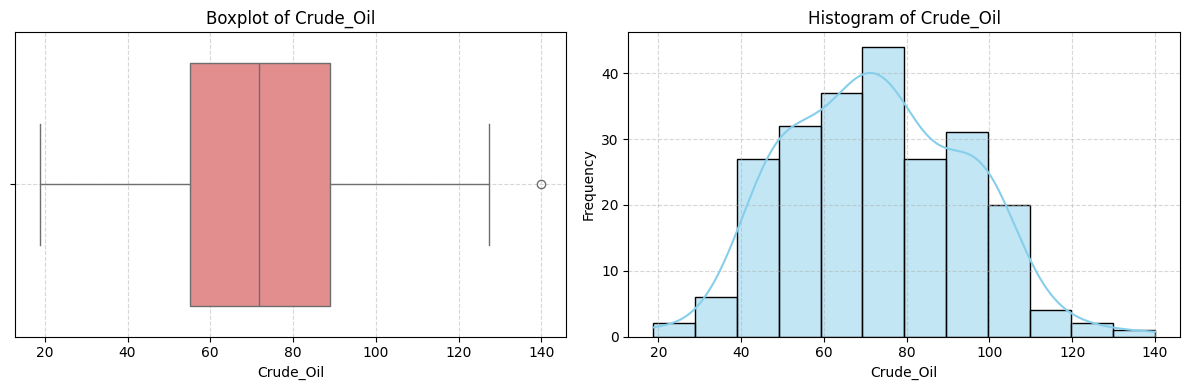

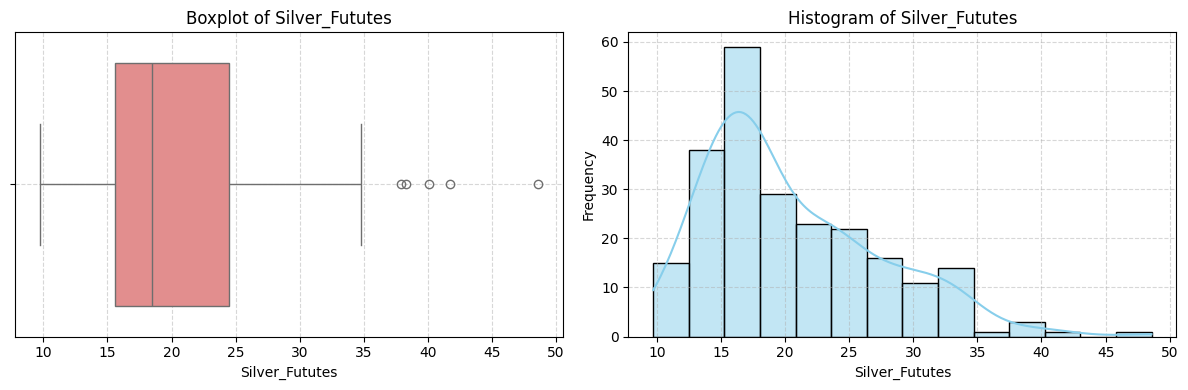

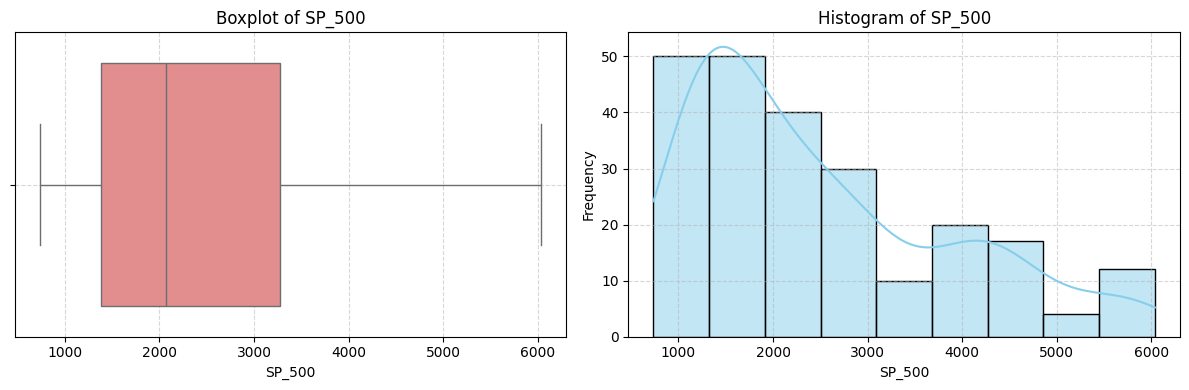

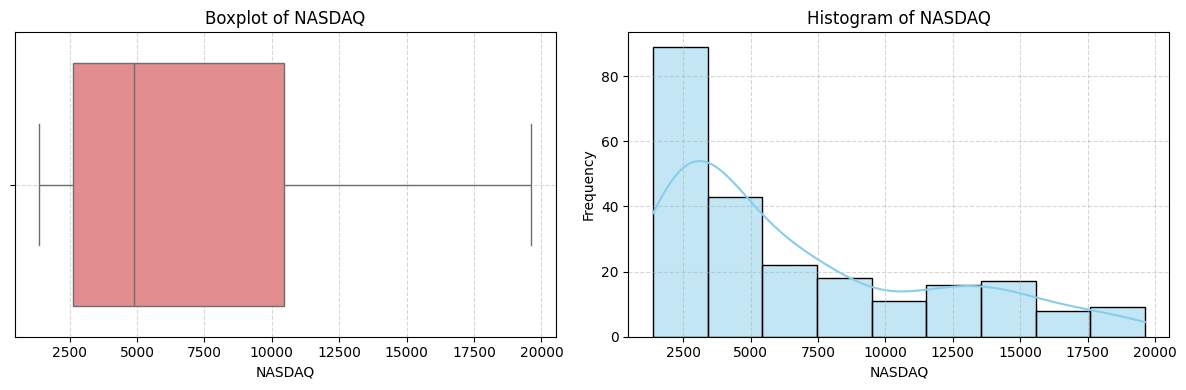

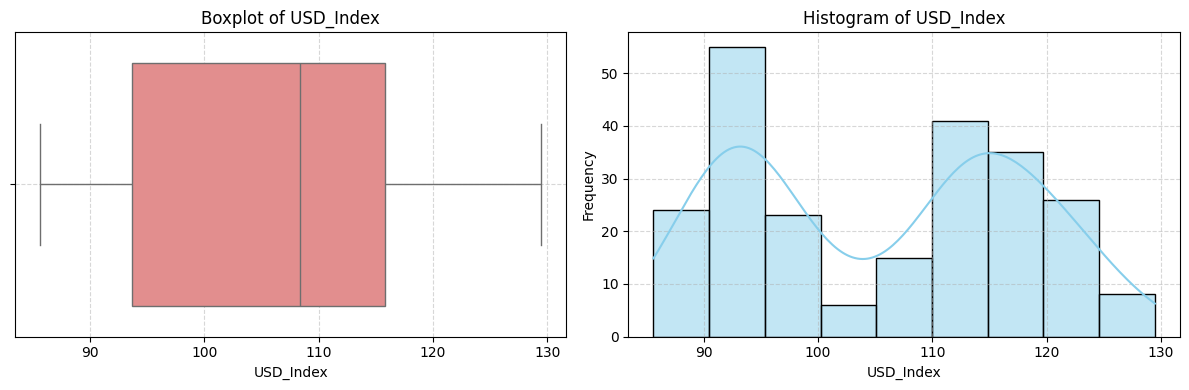

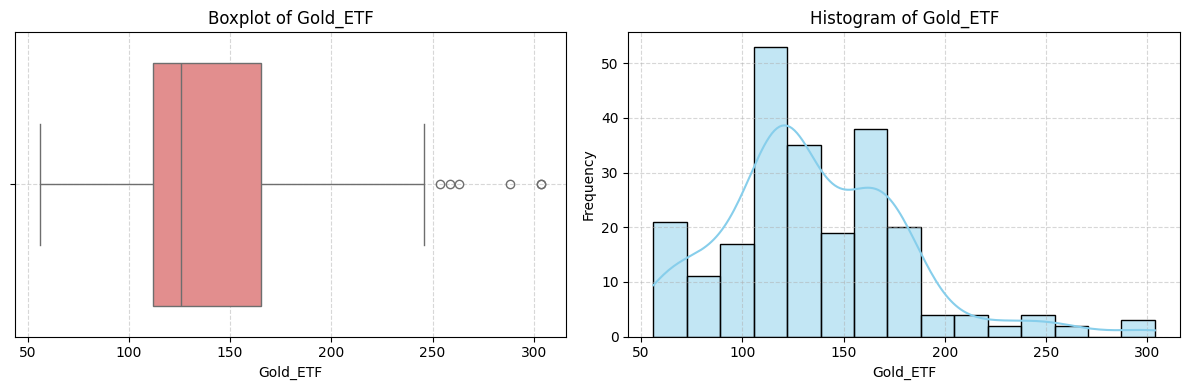

In [18]:
for col in market_indicator:
    fig, axes = plt.subplots(1,2, figsize=(12,4))

    sns.histplot(data=df, x=col, kde=True, ax=axes[1], color='skyblue', edgecolor='black')
    axes[1].set_title(f"Histogram of {col}")
    axes[1].set_xlabel(col)
    axes[1].set_ylabel("Frequency")
    axes[1].grid(True, linestyle='--', alpha=0.5)

    sns.boxplot(x=df[col], ax=axes[0], color='lightcoral')
    axes[0].set_title(f"Boxplot of {col}")
    axes[0].set_xlabel(col)
    axes[0].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

### Macroeconomic

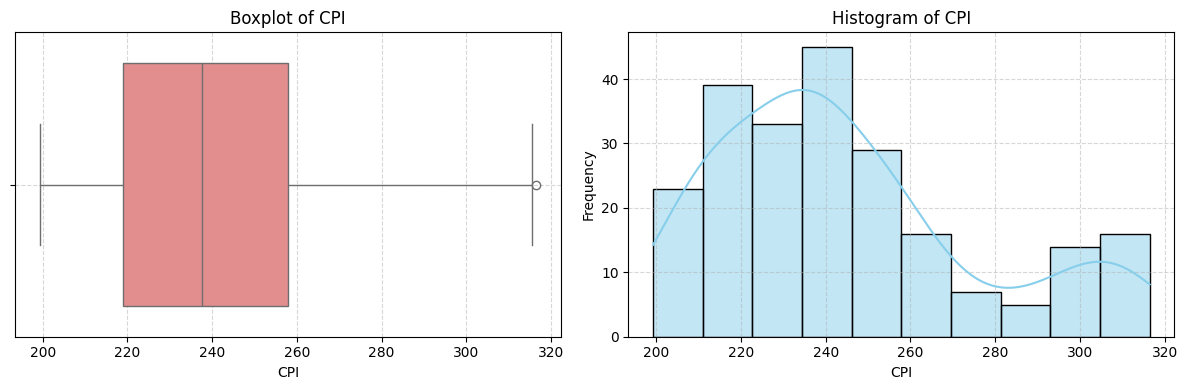

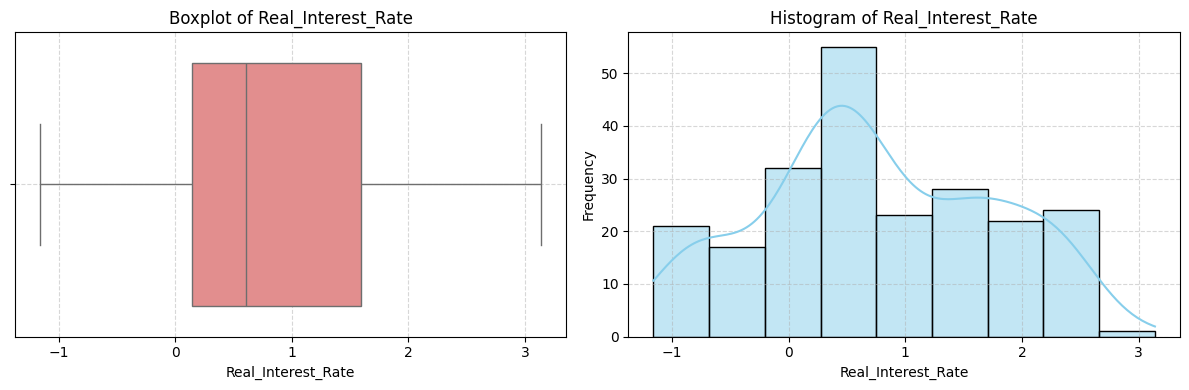

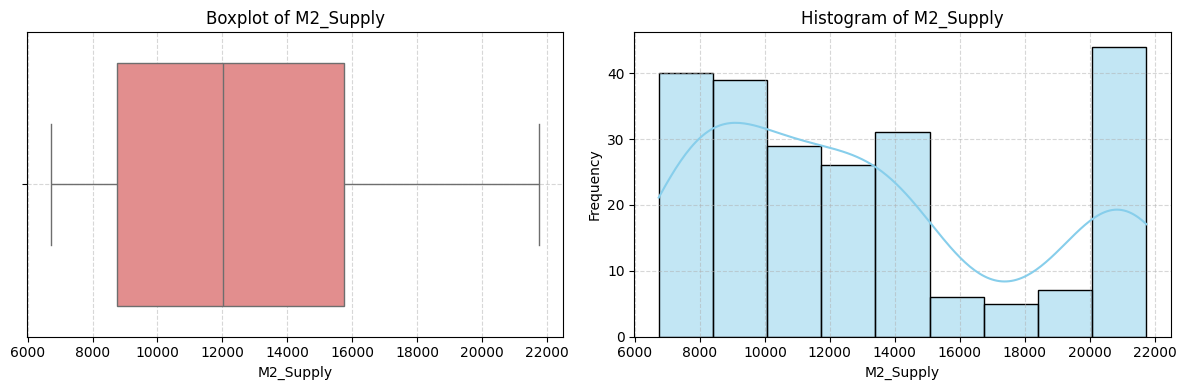

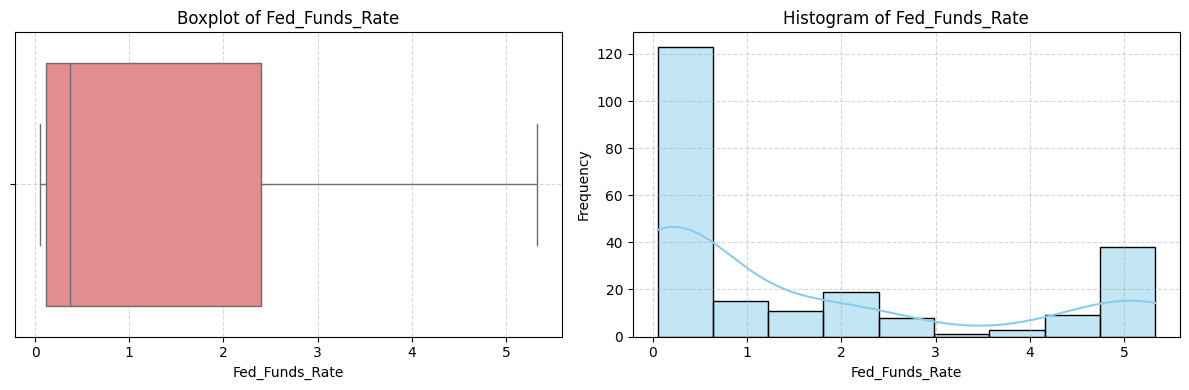

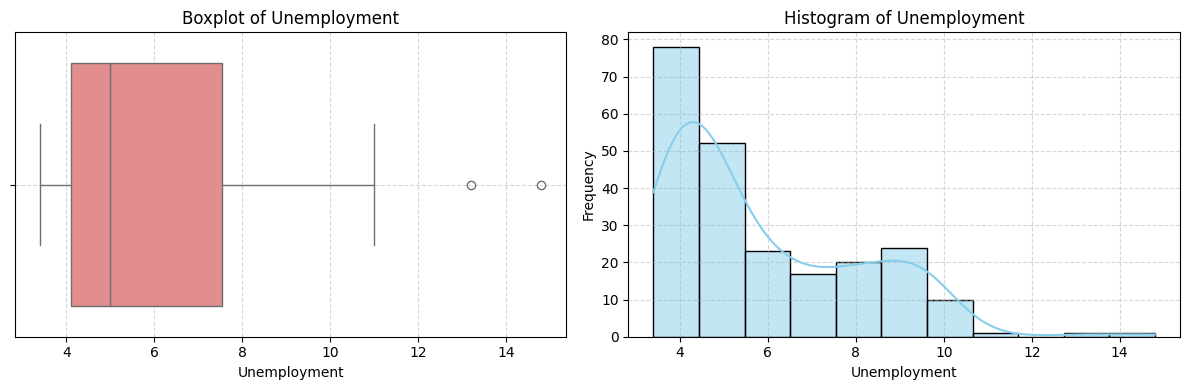

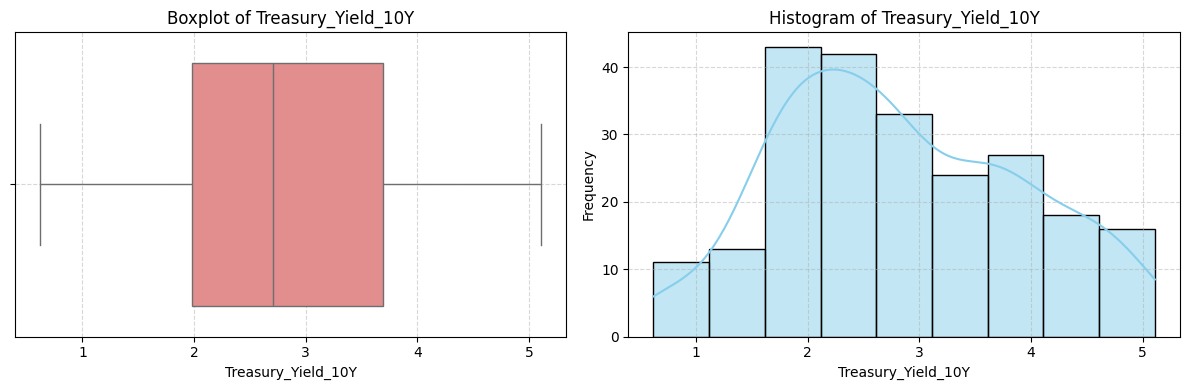

In [54]:
for col in macroeconomic:
    fig, axes = plt.subplots(1,2, figsize=(12,4))

    sns.histplot(data=df, x=col, kde=True, ax=axes[1], color='skyblue', edgecolor='black')
    axes[1].set_title(f"Histogram of {col}")
    axes[1].set_xlabel(col)
    axes[1].set_ylabel("Frequency")
    axes[1].grid(True, linestyle='--', alpha=0.5)

    sns.boxplot(x=df[col], ax=axes[0], color='lightcoral')
    axes[0].set_title(f"Boxplot of {col}")
    axes[0].set_xlabel(col)
    axes[0].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

### Volatility / Risk

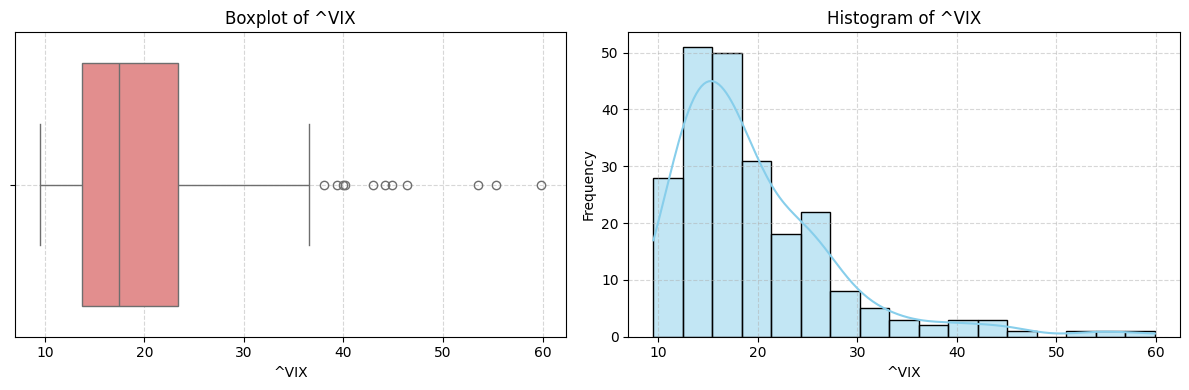

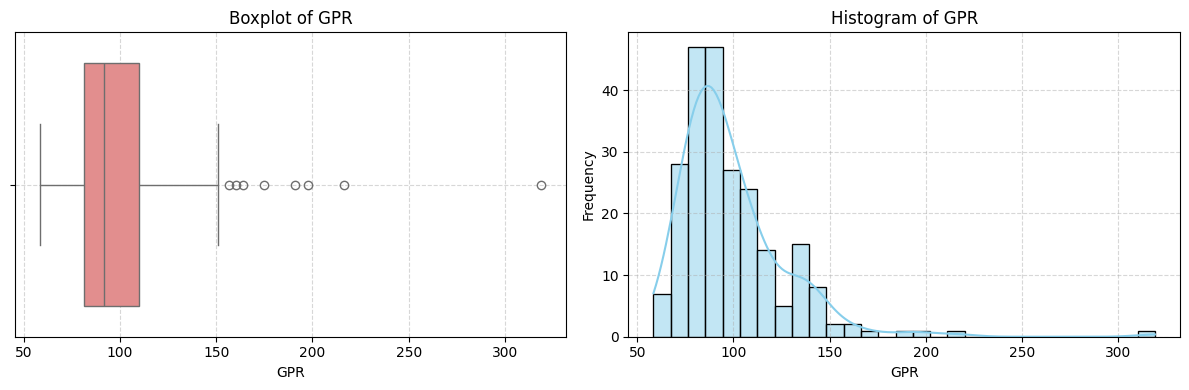

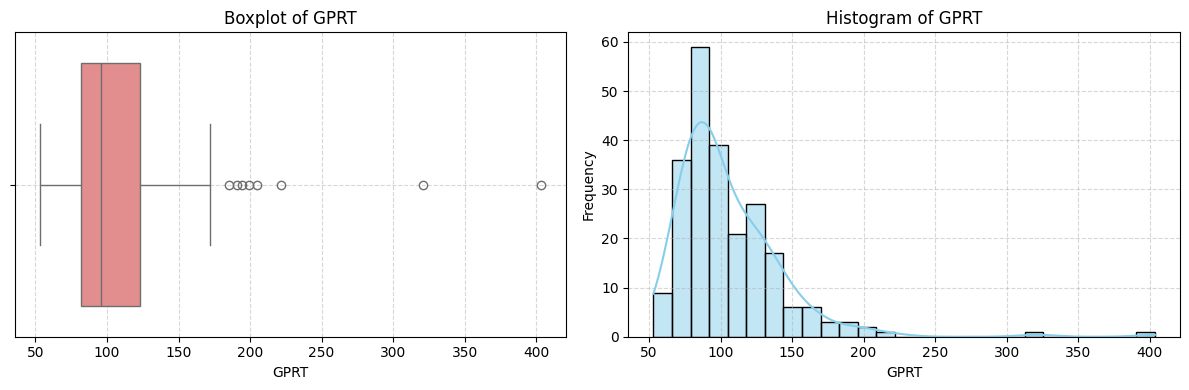

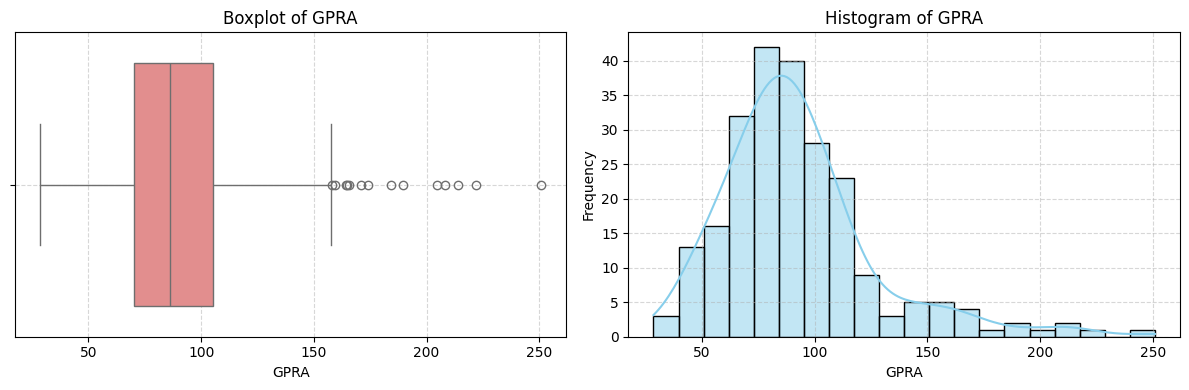

In [55]:
for col in votatility:
    fig, axes = plt.subplots(1,2, figsize=(12,4))

    sns.histplot(data=df, x=col, kde=True, ax=axes[1], color='skyblue', edgecolor='black')
    axes[1].set_title(f"Histogram of {col}")
    axes[1].set_xlabel(col)
    axes[1].set_ylabel("Frequency")
    axes[1].grid(True, linestyle='--', alpha=0.5)

    sns.boxplot(x=df[col], ax=axes[0], color='lightcoral')
    axes[0].set_title(f"Boxplot of {col}")
    axes[0].set_xlabel(col)
    axes[0].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

## Correlation

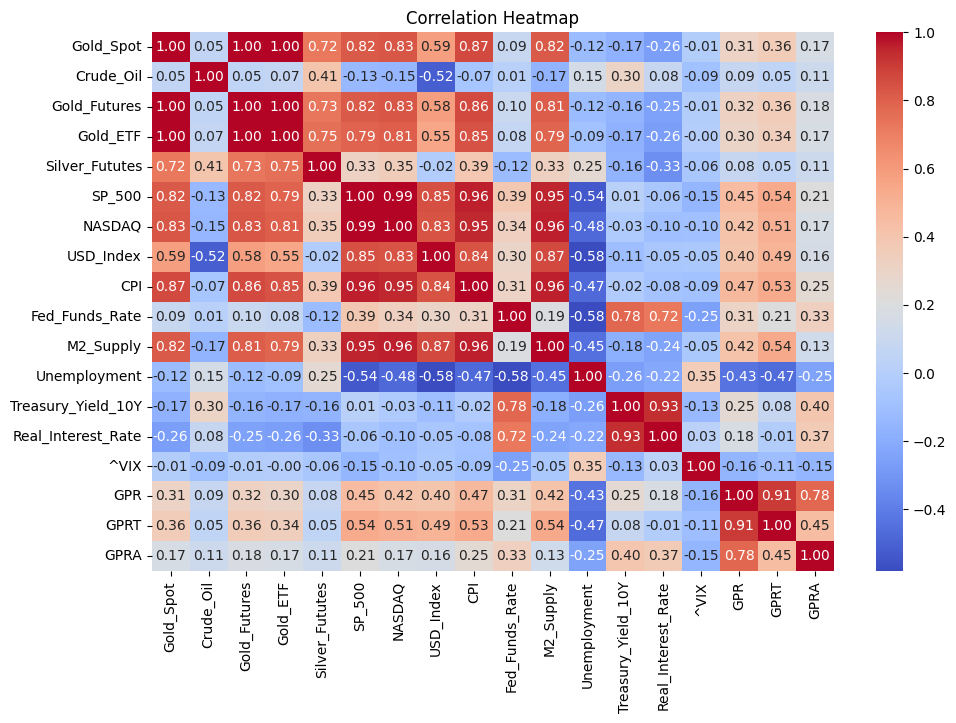

In [11]:
corr_matrix = df.corr()

plt.figure(figsize=(11, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [19]:
# Interactive Plotly Correlation Heatmap
import plotly.graph_objects as go

corr_matrix = df.corr()

fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale='RdBu_r',
    zmid=0,
    text=corr_matrix.values,
    texttemplate='%{text:.2f}',
    textfont={"size": 10},
    colorbar=dict(title="Correlation")
))

fig.update_layout(
    title="Full Feature Correlation Heatmap",
    width=1000,
    height=900,
    xaxis_title="Features",
    yaxis_title="Features",
    font=dict(size=10),
    xaxis_tickangle=90
)

fig.show()

In [20]:
# Save correlation heatmap
from pathlib import Path

CACHE_DIR = Path("../goldsight/data/cache")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

chart_name = "correlation_heatmap"
cache_file = CACHE_DIR / f"{chart_name}.json"
with open(cache_file, 'w') as f:
    f.write(fig.to_json())

print(f"Saved chart to {cache_file}")
print(f"To use in Reflex: rx.plotly(data=load_plotly_chart('{chart_name}'))")

Saved chart to ..\goldsight\data\cache\correlation_heatmap.json
To use in Reflex: rx.plotly(data=load_plotly_chart('correlation_heatmap'))


#### Variables with strong correlation to `Gold_Spot`
| Variable             | Corr with `Gold_Spot` | Meanings                                   |
| -------------------- | --------------------- | ------------------------------------------------ |
| `CPI`                | 0.85                  | ✅ Strong – closely related to inflation          |
| `M2_Supply`          | 0.82                  | ✅ Strong – supports monetary analysis            |
| `USD_Index`          | 0.55                  | ✅ Moderate – inverse relationship possible       |
| `NASDAQ` / `S&P_500` | \~0.80                | ✅ Keep one – avoid redundancy                    |
| `Silver_Futures`     | 0.71                  | ✅ Strong – precious metal relationship           |
| `Real_Interest_Rate` | -0.40                 | ✅ Negative correlation – highly relevant to gold |
| `GPRT`               | 0.36                  | ✅ Moderate – useful for geopolitical context     |
| `Treasury_Yield_10Y` | -0.34                 | ✅ Relevant – reflects interest rate environment  |

#### Variables with weak or insignificant correlation
| Variable         | Corr with `Gold_Spot` | Meanings                      |
| ---------------- | --------------------- | ----------------------------------- |
| `Crude_Oil`      | 0.09                  | ❌ Weak – little predictive power    |
| `Fed_Funds_Rate` | -0.03                 | ❌ Very weak – nearly no correlation |
| `^VIX`           | 0.00                  | ❌ Irrelevant – no apparent impact   |
| `GPRA`           | 0.17                  | ❌ Weak – limited value              |
| `Unemployment`   | -0.07                 | ❌ Weak – retained for now due to its potential nonlinear impact on gold prices.          |


**Comment**

#### Among the three gold-related indicators—`Gold_Spot`, `Gold_Futures`, and `Gold_ETF` choose `Gold_Spot`:
- Represents the actual physical price of gold in global markets.
- Less affected by speculative trading behavior(?).
- Aligns with the monthly frequency of macroeconomic indicators.

#### `S&P_500` vs `NASDAQ`(corr = 0.99)-> `S&P_500`
- `S&P_500` is more representative of the overall U.S. economy.
- `NASDAQ` is tech-heavy and more volatile.

#### `CPI` vs `M2_Supply`(corr = 0.96)-> `CPI`
- `CPI` (Consumer Price Index) directly reflects inflation.
- `M2_Supply` reflects the money supply, which indirectly affects inflation expectations.

#### `GPR` vs `GPRT`(corr = 0.91) -> `GPR`
- `GPR` (Geopolitical Risk) captures general geopolitical tensions such as wars and political instability.
- `GPRT` focuses specifically on geopolitical risks related to terrorism.

### Summary of Selected Variables:
| Feature Pair         | Selected Variable | Reason                                           |
|----------------------|-------------------|--------------------------------------------------|
| `Gold_Futures`, `Gold_ETF`, `Gold_Spot` | `Gold_Spot`        | Ground truth, monthly, less speculative          |
| `S&P_500`, `NASDAQ`  | `S&P_500`         | Broader, more stable                            |
| `CPI`, `M2_Supply`   | `CPI`             | Direct inflation indicator                      |
| `GPR`, `GPRT`        | `GPR`             | Broader geopolitical coverage    

## 2.Pre-processing

In [14]:
# ffill missing day and value market data
# market_data = pd.read_csv("../data/raw/market_data.csv", index_col='Date', parse_dates=True)
market_data = pd.read_csv("../data/raw/market_data.csv", index_col='Date', parse_dates=True)
market_data_copy = market_data.copy()
full_range = pd.date_range(start=market_data.index.min(), end=market_data.index.max(), freq='D')
market_data_copy = market_data_copy.reindex(full_range)
market_data_copy.ffill(inplace=True)
market_data_copy.reset_index(inplace=True)
market_data_copy.rename(columns={"index": "Date"}, inplace=True)
market_data_copy.to_csv("../data/processed/market_data_ffill.csv", index=False)

In [13]:
# ffill missing day and value vix data
vix_data = pd.read_csv("../data/raw/vix_data.csv", index_col='Date', parse_dates=True)
vix_ffill = vix_data.copy()
full_range = pd.date_range(start=vix_data.index.min(), end=vix_data.index.max(), freq='D')
vix_ffill = vix_ffill.reindex(full_range)
vix_ffill.ffill(inplace=True)
vix_ffill.reset_index(inplace=True)
vix_ffill.rename(columns={"index": "Date"}, inplace=True)
vix_ffill.to_csv("../data/processed/vix_ffill.csv", index=False)

In [11]:
# ffill missing day and value RIR data
RIR_data = pd.read_csv("../data/raw/real_interest_rate.csv", index_col='Date', parse_dates=True)
RIR_ffill = RIR_data.copy()
full_range = pd.date_range(start=RIR_data.index.min(), end=RIR_data.index.max(), freq='D')
RIR_ffill = RIR_ffill.reindex(full_range)
RIR_ffill.ffill(inplace=True)
RIR_ffill.reset_index(inplace=True)
RIR_ffill.rename(columns={"index": "Date"}, inplace=True)
RIR_ffill.to_csv("../data/processed/RIR_ffill.csv", index=False)

In [12]:
# ffill missing day and value USD data
usd_data = pd.read_csv("../data/raw/usd_index.csv", index_col='Date', parse_dates=True)

usd_ffill = usd_data.copy()
full_range = pd.date_range(start=usd_data.index.min(), end=usd_data.index.max(), freq='D')
usd_ffill = usd_ffill.reindex(full_range)
usd_ffill.ffill(inplace=True)
usd_ffill.reset_index(inplace=True)
usd_ffill.rename(columns={"index": "Date"}, inplace=True)
usd_ffill.to_csv("../data/processed/usd_ffill.csv", index=False)

In [13]:

df.rename(columns={"Silver_Fututes": "Silver_Futures"}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 233 entries, 2006-01-31 to 2025-05-30
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gold_Spot           233 non-null    float64
 1   Crude_Oil           233 non-null    float64
 2   Gold_Futures        233 non-null    float64
 3   Gold_ETF            233 non-null    float64
 4   Silver_Futures      233 non-null    float64
 5   SP_500              233 non-null    float64
 6   NASDAQ              233 non-null    float64
 7   USD_Index           233 non-null    float64
 8   CPI                 233 non-null    float64
 9   Fed_Funds_Rate      233 non-null    float64
 10  M2_Supply           233 non-null    float64
 11  Unemployment        233 non-null    float64
 12  Treasury_Yield_10Y  233 non-null    float64
 13  Real_Interest_Rate  233 non-null    float64
 14  ^VIX                233 non-null    float64
 15  GPR                 231 non-null    fl

In [14]:
selected_columns = [
    # Target
    "Gold_Spot",
    
    # Precious metals
    "Silver_Futures",
    
    # Stock market & volatility
    "SP_500", "^VIX",
    
    # Currencies & macro indicators
    "USD_Index", "CPI", "Unemployment",
    
    # Interest rates & yields
    "Treasury_Yield_10Y", "Real_Interest_Rate", "Fed_Funds_Rate",
    
    # Commodities
    "Crude_Oil",
    
    # Geopolitical risks
    "GPR", "GPRA"
]
filtered_df = df[selected_columns]
tools.display_dataframe_to_user(name="Filtered Data", dataframe=filtered_df)
filtered_df.to_csv("../data/filtered_data.csv")

Filtered Data


Loading ITables v2.4.3 from the internet... (need help?)


In [60]:
filtered_df.columns

Index(['Gold_Spot', 'Silver_Fututes', 'S&P_500', '^VIX', 'USD_Index', 'CPI',
       'Unemployment', 'Treasury_Yield_10Y', 'Real_Interest_Rate',
       'Fed_Funds_Rate', 'Crude_Oil', 'GPR', 'GPRA'],
      dtype='object')

In [20]:
filtered_df[filtered_df.isnull().any(axis=1)]


,Gold_Spot,Silver_Fututes,SP_500,^VIX,USD_Index,CPI,Unemployment,Treasury_Yield_10Y,Real_Interest_Rate,Fed_Funds_Rate,Crude_Oil,GPR,GPRA
Date,,,,,,,,,,,,,
2025-04-30,3207.48,32.530998,5569.060059,24.700001,122.9440,320.321,4.2,4.28,1.94,4.33,58.209999,NaN,NaN
2025-05-30,3277.99,32.891998,5911.689941,18.570000,122.1112,320.580,4.2,4.42,2.07,4.33,60.790001,NaN,NaN


## Generic Save Template

Copy this code after creating any Plotly chart. Just change the `chart_name` variable to match your chart.

In [21]:
# ============================================================
# GENERIC SAVE TEMPLATE - Use this for all charts
# ============================================================
from pathlib import Path

# Define cache directory (create if doesn't exist)
CACHE_DIR = Path("../goldsight/data/cache")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# CHANGE THIS for each chart you create
chart_name = "your_chart_name_here"  # Examples: "correlation_matrix", "gold_timeseries", "vix_distribution"

# Save the figure (assumes 'fig' variable exists from previous cell)
cache_file = CACHE_DIR / f"{chart_name}.json"
with open(cache_file, 'w') as f:
    f.write(fig.to_json())

print(f"Saved chart to {cache_file}")
print(f"To use in Reflex: rx.plotly(data=load_plotly_chart('{chart_name}'))")

Saved chart to ..\goldsight\data\cache\your_chart_name_here.json
To use in Reflex: rx.plotly(data=load_plotly_chart('your_chart_name_here'))


## Example: Gold Currency Heatmap

This shows how the generic template was used for the first chart.

In [ ]:
# Example usage of the generic template for gold currency heatmap
from pathlib import Path

CACHE_DIR = Path("../goldsight/data/cache")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

chart_name = "gold_currency_heatmap"  

# Assuming 'fig' was created in a previous cell with the gold currency heatmap
cache_file = CACHE_DIR / f"{chart_name}.json"
with open(cache_file, 'w') as f:
    f.write(fig.to_json())

print(f"Saved chart to {cache_file}")
print(f"To use in Reflex: rx.plotly(data=load_plotly_chart('{chart_name}'))")

Saved chart to ..\goldsight\data\cache\gold_currency_heatmap.json
To use in Reflex: rx.plotly(data=load_plotly_chart('gold_currency_heatmap'))


## Distribution Charts for EDA Page

Creating 4 grouped distribution charts:
1. **Target Variable**: Gold Spot only (boxplot + histogram)
2. **Market Indicators**: S&P 500, USD Index, Silver, Crude Oil
3. **Macroeconomic**: CPI, Unemployment, Fed Rate, Treasury 10Y, Real Interest Rate
4. **Volatility & Risk**: VIX, GPR, GPRA

These will be displayed in a tabbed interface in the Reflex app.

In [7]:
# 1. Target Variable Distribution - Gold Spot Only
from plotly.subplots import make_subplots
import plotly.graph_objects as go

filtered_df = pd.read_csv("../data/filtered_data.csv", index_col='Date', parse_dates=True)

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=['Gold Spot - Boxplot', 'Gold Spot - Histogram'],
    horizontal_spacing=0.15
)

# Boxplot
fig.add_trace(
    go.Box(
        y=filtered_df['Gold_Spot'],
        name='Gold Spot',
        marker=dict(color='goldenrod'),
        boxmean='sd'  # Show mean and standard deviation
    ),
    row=1, col=1
)

# Histogram with KDE curve approximation
fig.add_trace(
    go.Histogram(
        x=filtered_df['Gold_Spot'],
        name='Gold Spot',
        marker=dict(color='goldenrod', line=dict(color='darkgoldenrod', width=1)),
        nbinsx=30,
        histnorm='probability density'
    ),
    row=1, col=2
)

# Add statistical annotations
mean_val = filtered_df['Gold_Spot'].mean()
median_val = filtered_df['Gold_Spot'].median()
std_val = filtered_df['Gold_Spot'].std()

fig.add_annotation(
    text=f"Mean: ${mean_val:.2f}<br>Median: ${median_val:.2f}<br>Std: ${std_val:.2f}",
    xref="paper", yref="paper",
    x=0.98, y=0.98,
    showarrow=False,
    bgcolor="rgba(255, 215, 0, 0.1)",
    bordercolor="goldenrod",
    borderwidth=1,
    font=dict(size=10),
    align="left",
    xanchor="right",
    yanchor="top"
)

fig.update_layout(
    title="Target Variable Distribution: Gold Spot (2006-2025)",
    showlegend=False,
    width=1200,
    height=500,
    template='plotly_white'
)

fig.update_xaxes(title_text="Gold Price (USD)", row=1, col=2)
fig.update_yaxes(title_text="Frequency Density", row=1, col=2)
fig.update_yaxes(title_text="Gold Price (USD)", row=1, col=1)

fig.show()

In [8]:
# Save gold_distributions chart
from pathlib import Path

CACHE_DIR = Path("../goldsight/data/cache")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

chart_name = "gold_distributions"
cache_file = CACHE_DIR / f"{chart_name}.json"
with open(cache_file, 'w') as f:
    f.write(fig.to_json())

print(f"Saved chart to {cache_file}")
print(f"To use in Reflex: rx.plotly(data=load_plotly_chart('{chart_name}'))")

Saved chart to ..\goldsight\data\cache\gold_distributions.json
To use in Reflex: rx.plotly(data=load_plotly_chart('gold_distributions'))


In [10]:
# 2. Market Indicators Distribution

market_features = ['SP_500', 'USD_Index', 'Silver_Futures', 'Crude_Oil']

fig = make_subplots(
    rows=2, cols=4,
    subplot_titles=[
        'S&P 500 - Box', 'S&P 500 - Hist',
        'USD Index - Box', 'USD Index - Hist',
        'Silver - Box', 'Silver - Hist',
        'Crude Oil - Box', 'Crude Oil - Hist'
    ],
    vertical_spacing=0.12,
    horizontal_spacing=0.08
)

colors = ['blue', 'green', 'silver', 'brown']

for idx, (feature, color) in enumerate(zip(market_features, colors)):
    row = idx // 2 + 1
    col_box = (idx % 2) * 2 + 1
    col_hist = col_box + 1
    
    # Boxplot
    fig.add_trace(
        go.Box(
            y=filtered_df[feature],
            name=feature,
            marker=dict(color=color),
            showlegend=False
        ),
        row=row, col=col_box
    )
    
    # Histogram
    fig.add_trace(
        go.Histogram(
            x=filtered_df[feature],
            name=feature,
            marker=dict(color=color, line=dict(color='black', width=0.5)),
            nbinsx=25,
            showlegend=False
        ),
        row=row, col=col_hist
    )

fig.update_layout(
    title="Market Indicators Distribution (2006-2025)",
    width=1200,
    height=600,
    template='plotly_white',
    showlegend=False
)

fig.show()

In [11]:
# Save market_distributions chart
chart_name = "market_distributions"
cache_file = CACHE_DIR / f"{chart_name}.json"
with open(cache_file, 'w') as f:
    f.write(fig.to_json())

print(f"Saved chart to {cache_file}")
print(f"To use in Reflex: rx.plotly(data=load_plotly_chart('{chart_name}'))")

Saved chart to ..\goldsight\data\cache\market_distributions.json
To use in Reflex: rx.plotly(data=load_plotly_chart('market_distributions'))


In [12]:
# 3. Macroeconomic Indicators Distribution
filtered_df = pd.read_csv("../data/filtered_data.csv", index_col='Date', parse_dates=True)

macro_features = ['CPI', 'Unemployment', 'Fed_Funds_Rate', 'Treasury_Yield_10Y', 'Real_Interest_Rate']

# Need 3 rows to fit 5 features (2 features per row, last row has 1)
fig = make_subplots(
    rows=3, cols=4,
    subplot_titles=[
        'CPI - Box', 'CPI - Hist',
        'Unemployment - Box', 'Unemployment - Hist',
        'Fed Rate - Box', 'Fed Rate - Hist',
        'Treasury 10Y - Box', 'Treasury 10Y - Hist',
        'Real IR - Box', 'Real IR - Hist'
    ],
    vertical_spacing=0.10,
    horizontal_spacing=0.08,
    specs=[
        [{"type": "box"}, {"type": "histogram"}, {"type": "box"}, {"type": "histogram"}],
        [{"type": "box"}, {"type": "histogram"}, {"type": "box"}, {"type": "histogram"}],
        [{"type": "box"}, {"type": "histogram"}, None, None]
    ]
)

colors = ['orange', 'red', 'purple', 'teal', 'navy']

for idx, (feature, color) in enumerate(zip(macro_features, colors)):
    row = idx // 2 + 1
    col_box = (idx % 2) * 2 + 1
    col_hist = col_box + 1
    
    # Boxplot
    fig.add_trace(
        go.Box(
            y=filtered_df[feature],
            name=feature,
            marker=dict(color=color),
            showlegend=False
        ),
        row=row, col=col_box
    )
    
    # Histogram
    fig.add_trace(
        go.Histogram(
            x=filtered_df[feature],
            name=feature,
            marker=dict(color=color, line=dict(color='black', width=0.5)),
            nbinsx=25,
            showlegend=False
        ),
        row=row, col=col_hist
    )

fig.update_layout(
    title="Macroeconomic Indicators Distribution (2006-2025)",
    width=1200,
    height=800,
    template='plotly_white',
    showlegend=False
)

fig.show()

In [13]:
# Save macro_distributions chart
chart_name = "macro_distributions"
cache_file = CACHE_DIR / f"{chart_name}.json"
with open(cache_file, 'w') as f:
    f.write(fig.to_json())

print(f"Saved chart to {cache_file}")
print(f"To use in Reflex: rx.plotly(data=load_plotly_chart('{chart_name}'))")

Saved chart to ..\goldsight\data\cache\macro_distributions.json
To use in Reflex: rx.plotly(data=load_plotly_chart('macro_distributions'))


In [14]:
# 4. Volatility & Risk Indicators Distribution
filtered_df = pd.read_csv("../data/filtered_data.csv", index_col='Date', parse_dates=True)

volatility_features = ['^VIX', 'GPR', 'GPRA']

fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=[
        'VIX - Box', 'VIX - Hist',
        'GPR - Box', 'GPR - Hist',
        'GPRA - Box', 'GPRA - Hist'
    ],
    vertical_spacing=0.15,
    horizontal_spacing=0.10,
    specs=[
        [{"type": "box"}, {"type": "histogram"}, None],
        [{"type": "box"}, {"type": "histogram"}, {"type": "box"}],
    ]
)

colors = ['crimson', 'darkred', 'firebrick']

# VIX - row 1
fig.add_trace(
    go.Box(y=filtered_df['^VIX'], name='VIX', marker=dict(color=colors[0]), showlegend=False),
    row=1, col=1
)
fig.add_trace(
    go.Histogram(x=filtered_df['^VIX'], name='VIX', marker=dict(color=colors[0], line=dict(color='black', width=0.5)), nbinsx=25, showlegend=False),
    row=1, col=2
)

# GPR - row 2
fig.add_trace(
    go.Box(y=filtered_df['GPR'], name='GPR', marker=dict(color=colors[1]), showlegend=False),
    row=2, col=1
)
fig.add_trace(
    go.Histogram(x=filtered_df['GPR'], name='GPR', marker=dict(color=colors[1], line=dict(color='black', width=0.5)), nbinsx=25, showlegend=False),
    row=2, col=2
)

# GPRA - row 2, col 3 (boxplot only, no histogram for layout balance)
fig.add_trace(
    go.Box(y=filtered_df['GPRA'], name='GPRA', marker=dict(color=colors[2]), showlegend=False),
    row=2, col=3
)

fig.update_layout(
    title="Volatility & Risk Indicators Distribution (2006-2025)",
    width=1000,
    height=600,
    template='plotly_white',
    showlegend=False
)

fig.show()

In [15]:
# Save volatility_distributions chart
chart_name = "volatility_distributions"
cache_file = CACHE_DIR / f"{chart_name}.json"
with open(cache_file, 'w') as f:
    f.write(fig.to_json())

print(f"Saved chart to {cache_file}")
print(f"To use in Reflex: rx.plotly(data=load_plotly_chart('{chart_name}'))")

Saved chart to ..\goldsight\data\cache\volatility_distributions.json
To use in Reflex: rx.plotly(data=load_plotly_chart('volatility_distributions'))
